# Title I Allocations w/ DP ACS

## Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [1]:
%load_ext autoreload
%autoreload 2

from dp_policy.titlei.utils import get_sppe
import pandas as pd

sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

,state,ppe,abbrv
0,Alabama,9697,AL
1,Alaska,17726,AK
2,American Samoa,NaN,AS
3,Arizona,8296,AZ
4,Arkansas,10072,AR


Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [129]:
from dp_policy.titlei.utils import get_saipe

saipe = get_saipe("../data/saipe19.xls")
saipe.head()

State Postal Code  \
State FIPS Code District ID                     
1               190                        AL   
                5                          AL   
                30                         AL   
                60                         AL   
                90                         AL   

                                                            Name  \
State FIPS Code District ID                                        
1               190               Alabaster City School District   
                5               Albertville City School District   
                30           Alexander City City School District   
                60                Andalusia City School District   
                90                 Anniston City School District   

                             Estimated Total Population  \
State FIPS Code District ID                               
1               190                               34669   
                5                                 22051   
                30                                16920   
                60                                 8842   
                90                                22043   

                             Estimated Population 5-17  \
State FIPS Code District ID                              
1               190                               6710   
                5                                 4131   
                30                                2575   
                60                                1465   
                90                                3065   

                             Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder  \
State FIPS Code District ID                                                                                                          
1               190                                                        649                                                       
                5                                                          957                                                       
                30                                                         703                                                       
                60                                                         406                                                       
                90                                                        1057                                                       

                             median_cv  
State FIPS Code District ID             
1               190               0.23  
                5                 0.23  
                30                0.28  
                60                0.35  
                90                0.23

### Code

In [5]:
from dp_policy.titlei.mechanisms import GroundTruth

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

In [6]:
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting

weighting(1559, 10000)

1993.0

Finally, the main method for computing estimates, then grant amounts.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


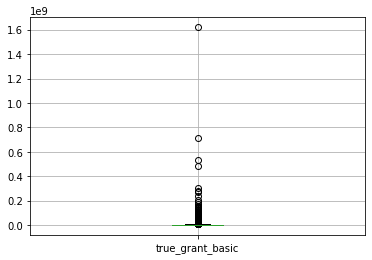

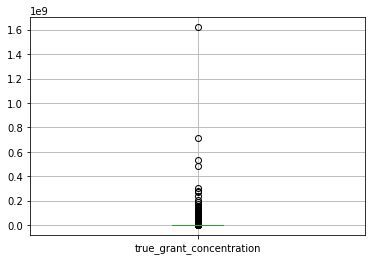

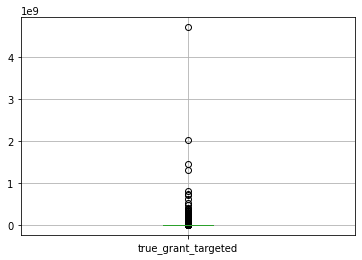

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from dp_policy.api import titlei_funding as funding

# Test with ground truth mechanism
grants = funding(saipe, SonnenbergAuthorizer, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"), weighting)
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Laplace
### Data
From [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) release.

### Mechanism

In [12]:
from dp_policy.titlei.mechanisms import Laplace
        
Laplace(saipe, 0.1, 0).poverty_estimates()

(District ID
 190     3.467120e+04
 5       2.205009e+04
 30      1.692302e+04
 60      8.848746e+03
 90      2.205139e+04
             ...     
 6240    7.129524e+03
 5820    6.714197e+02
 4830    5.479953e+03
 6090    1.480246e+03
 30      3.193700e+06
 Name: Estimated Total Population, Length: 13184, dtype: float64,
 District ID
 190       6712.110858
 5         4129.507787
 30        2563.452255
 60        1468.574430
 90        3050.100416
             ...      
 6240      1292.116195
 5820        72.947636
 4830       819.372061
 6090       243.050757
 30      455247.184117
 Name: Estimated Population 5-17, Length: 13184, dtype: float64,
 District ID
 190        675.962885
 5          954.133469
 30         696.057828
 60         404.588776
 90        1057.570598
             ...      
 6240       168.869777
 5820        72.625771
 4830       106.431276
 6090         6.996193
 30      248617.363718
 Name: Estimated number of relevant children 5 to 17 years old in poverty who are 

### Results
First, using the full Sonnenberg authorization algo.

In [13]:
grants = funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 5, 0), get_sppe("../data/sppe18.xlsx"), weighting)
grants.describe()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


,State FIPS Code,true_pop_total,true_children_total,true_children_poverty,median_cv,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,est_children_eligible,sppe,true_grant_basic,true_grant_concentration,true_grant_targeted,est_grant_basic,est_grant_concentration,est_grant_targeted
count,13182.000000,1.318200e+04,1.318200e+04,13182.000000,13182.000000,1.318200e+04,1.318200e+04,13182.000000,13182.000000,13182.000000,13182.000000,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04
mean,29.561751,2.651938e+04,4.049290e+03,625.253224,0.383360,2.651938e+04,4.049291e+03,625.255551,625.253224,625.255551,13027.845092,3.026463e+06,2.231939e+06,5.062192e+06,3.026334e+06,2.231652e+06,5.061872e+06
std,14.644764,1.155746e+05,1.728792e+04,3467.140325,0.171494,1.155746e+05,1.728792e+04,3467.134095,3467.140325,3467.134095,3667.794832,1.912444e+07,1.908713e+07,5.239813e+07,1.912443e+07,1.908711e+07,5.239806e+07
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.150000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,7525.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,18.000000,2.802000e+03,4.260000e+02,52.000000,0.230000,2.801340e+03,4.261179e+02,52.081310,52.000000,52.081310,10157.000000,2.617935e+05,0.000000e+00,1.924048e+05,2.614427e+05,0.000000e+00,1.927023e+05
50%,30.000000,7.911000e+03,1.186000e+03,147.000000,0.350000,7.911045e+03,1.186452e+03,147.098848,147.000000,147.098848,12159.000000,7.504039e+05,0.000000e+00,7.283281e+05,7.495703e+05,0.000000e+00,7.280138e+05
75%,40.000000,2.101825e+04,3.222000e+03,411.000000,0.420000,2.101795e+04,3.222037e+03,411.088004,411.000000,411.088004,15780.000000,2.076117e+06,9.130432e+05,2.294255e+06,2.076825e+06,9.129953e+05,2.291401e+06
max,56.000000,8.336817e+06,1.193045e+06,259012.000000,0.670000,8.336817e+06,1.193045e+06,259011.688993,259012.000000,259011.688993,22845.000000,1.619697e+09,1.619697e+09,4.714287e+09,1.619695e+09,1.619695e+09,4.714281e+09


In [35]:
import itertools

def test_params(mech, eps=list(np.logspace(-3, 1)) + [2.5], delta=[0.0]):
    allocations = []
    print(f"{len(eps)*len(delta)} iters:")
    i = 0
    for d in delta:
        for e in eps:
            print(i, end=" ")
            i += 1
            allocations.append(funding(
                saipe, 
                SonnenbergAuthorizer, 
                mech(saipe, e, d), 
                get_sppe("../data/sppe18.xlsx"), 
                weighting, 
                verbose=False)
            )
    return pd.concat(allocations, axis=0, join="inner", keys=itertools.product(delta, eps), names=["delta", "epsilon", "id"])

def plot_results(results):
    for grant_type in ("basic", "concentration", "targeted"):
        print(f"## {grant_type} grants ##")
        
        eps, allocations = list(zip(*results.groupby("epsilon")))
        
        mse = []
        for e, alloc in results.groupby("epsilon"):
            error = alloc[f"true_grant_{grant_type}"]-alloc[f"est_grant_{grant_type}"]
            mse.append(np.sqrt(sum(error**2)/alloc.shape[0]))
            if (e == 2.5) or (e > 0.1 and e < 0.11):
                print(f"RMSE at eps={e}:", np.sqrt(np.mean(error**2)))
                print(f"Total misalloc at eps={e}:", sum(abs(error)))
                print("Total true alloc:", sum(alloc[f"true_grant_{grant_type}"]))

        plt.plot(eps, mse)
        ax = plt.gca()
        ax.set_xscale('log')
        plt.xlabel("Epsilon")
        plt.ylabel(f"{grant_type} grant RMSE, nationally")
        plt.show()

        for i in [0, 25, -2]:
            e = eps[i]
            alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
            alloc = alloc.sort_values(f"true_grant_{grant_type}")
            ids = alloc.index.get_level_values("id").astype('str')
            plt.scatter(ids, alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]), s=2, alpha=0.3, label=f"eps={e}")
        plt.scatter(ids, alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), s=2, alpha=0.3, label="true")
        ax = plt.gca()
        ax.legend()
        ax.axes.xaxis.set_ticks([])
        ax.set_yscale('log')
        plt.xlabel("District (sorted by true alloc)")
        plt.ylabel("Allocation (as %)")
        plt.title(f"{grant_type} grants for Michigan")
        plt.show()

        for i in [0, 25, -2]:
            e = eps[i]
            alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
            alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6
            plt.scatter(alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), alloc.err_prop, s=3, alpha=0.4, label=f"eps={e}")
        ax = plt.gca()
        ax.legend()
        ax.set_xscale('log')
        ax.set_yscale('log')
        plt.xlabel("True allocation as % of total")
        plt.ylabel("Misallocation per million as % of total")
        plt.title(f"{grant_type} grants for Michigan")
        plt.show()

test_params(Laplace, eps=[0.1, 1.0], delta=[0.0])

SyntaxError: EOL while scanning string literal (<ipython-input-35-569390399e19>, line 5)

In [16]:
results = test_params(Laplace)
results.to_csv("../results/titlei_laplace.csv")

## basic grants ##
RMSE at eps=0.10985411419875583: 65743.30291987311
Total misalloc at eps=0.10985411419875583: 599018276.033887
Total true alloc: 39894838662.272514
RMSE at eps=2.5: 4017.418530032202
Total misalloc at eps=2.5: 27148744.818973493
Total true alloc: 39894838662.272514


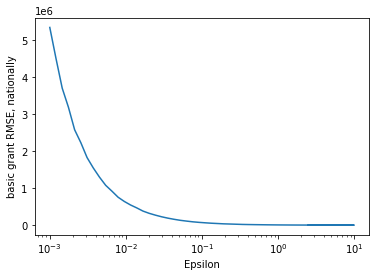

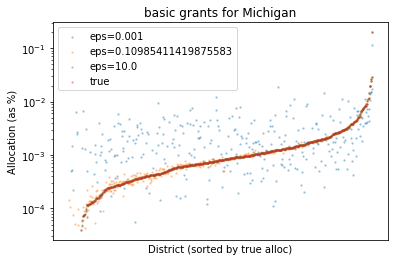

<ipython-input-17-3a3ab05b33c6>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


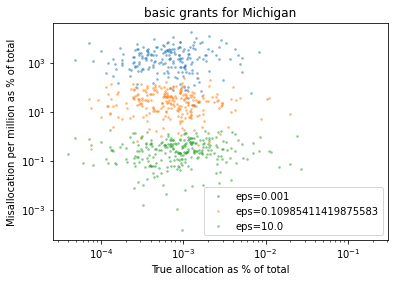

## concentration grants ##
RMSE at eps=0.10985411419875583: 204948.95655322267
Total misalloc at eps=0.10985411419875583: 609654484.3940177
Total true alloc: 29421416873.03583
RMSE at eps=2.5: 26247.798471886817
Total misalloc at eps=2.5: 22866650.981359735
Total true alloc: 29421416873.03583


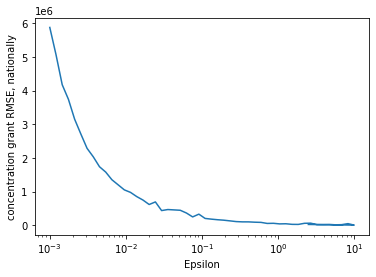

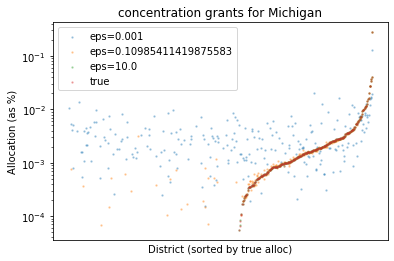

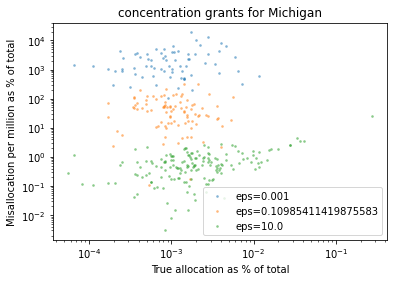

## targeted grants ##
RMSE at eps=0.10985411419875583: 132512.49683141144
Total misalloc at eps=0.10985411419875583: 951465300.8885156
Total true alloc: 66729811774.698265
RMSE at eps=2.5: 25005.4518058
Total misalloc at eps=2.5: 46155782.058760285
Total true alloc: 66729811774.698265


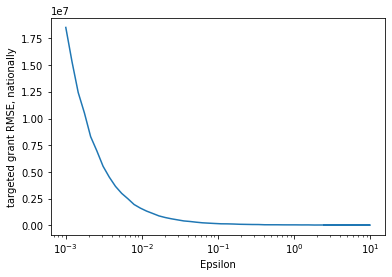

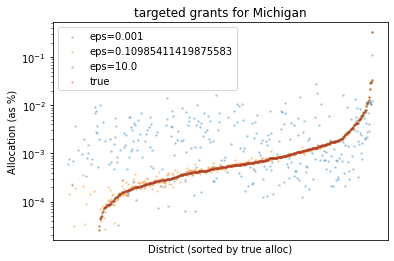

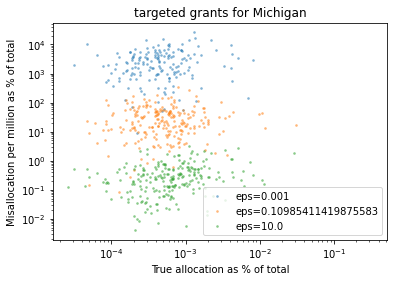

In [17]:
plot_results(results)

### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [18]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting)
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
Mean Sq. SPPE (2018): 26235395.69087739


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [19]:
# RMSE
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

2886.086015950252

In [20]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 26455555.64417489


In [21]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 4.74, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


1532.2698056226236

In [22]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 0.1, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


70356.30071987885

So we get some small differences due to inflation or due to other differences in data, but roughly the same values. Biggest difference is in SPPE - apparenlty spending has increased since 2014.

### Uncertainty

The simplest approximate measure of uncertainty is given by the Census's median coefficient of varation in the poverty estimates for each district. We can construct a confidence interval for each allocation as follows, ignoring variance due to missing cutoffs (for now) by using the Abowd method.

In [23]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting)
grants.head()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


,State Postal Code,State FIPS Code,Name,true_pop_total,true_children_total,true_children_poverty,median_cv,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,est_children_eligible,sppe,adj_sppe,true_allocation,est_allocation
0,AL,1,Alabaster City School District,34669,6710,649,0.23,34668.807941,6710.421602,649.041502,649,649.041502,9697.0,4168.910429,2.705623e+06,2.705796e+06
1,AL,1,Albertville City School District,22051,4131,957,0.23,22050.732493,4131.096921,957.107551,957,957.107551,9697.0,4168.910429,3.989647e+06,3.990096e+06
2,AL,1,Alexander City City School District,16920,2575,703,0.28,16920.177612,2575.326905,702.300494,703,702.300494,9697.0,4168.910429,2.930744e+06,2.927828e+06
3,AL,1,Andalusia City School District,8842,1465,406,0.35,8842.122735,1464.397793,405.824288,406,405.824288,9697.0,4168.910429,1.692578e+06,1.691845e+06
4,AL,1,Anniston City School District,22043,3065,1057,0.23,22043.013546,3064.659742,1057.263264,1057,1057.263264,9697.0,4168.910429,4.406538e+06,4.407636e+06


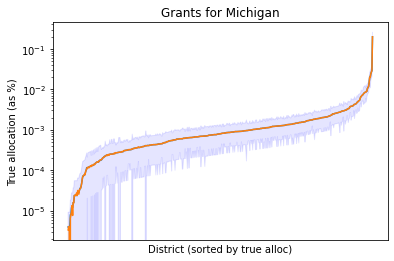

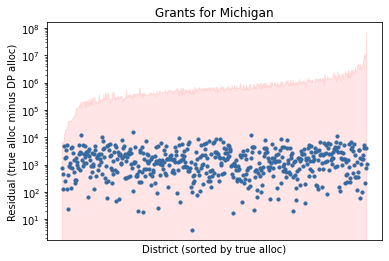

In [24]:
def plot_uncertainty(grants):
    grants = grants[grants["State Postal Code"] == "MI"].sort_values("true_allocation")
    x = grants.index.astype('str')
    y = grants.true_allocation / sum(grants.true_allocation)
    plt.plot(x, y)
    ax = plt.gca()
    prop_ci = 1.96 * grants.median_cv * y
    ax.fill_between(x, (y-prop_ci), (y+prop_ci), color='b', alpha=0.1)

    plt.plot(x, grants.est_allocation / sum(grants.est_allocation))

    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("True allocation (as %)")
    plt.title(f"Grants for Michigan")
    plt.show()
    
    y = np.abs(grants.true_allocation - grants.est_allocation)
    plt.scatter(x, y, s=10)

    ax = plt.gca()
    ci = 1.96 * grants.median_cv * grants.true_allocation
    ax.fill_between(x, ci, color='r', alpha=0.1)

    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Residual (true alloc minus DP alloc)")
    plt.title(f"Grants for Michigan")
    plt.show()

plot_uncertainty(grants)

## Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.

In [34]:
from dp_policy.titlei.mechanisms import Gaussian

# with delta = 0
results = test_params(
    Gaussian, 
    eps=list(np.logspace(-3, 0)), 
    delta=list(np.linspace(0.02, 1, endpoint=False, num=10))
)
results.to_csv("../results/titlei_gaussian.csv")

0.001 0.0011513953993264468 0.0013257113655901094 0.0015264179671752333 0.0017575106248547913 0.0020235896477251575 0.002329951810515372 0.0026826957952797246 0.0030888435964774815 0.0035564803062231283 0.004094915062380427 0.004714866363457394 0.005428675439323859 0.006250551925273976 0.0071968567300115215 0.008286427728546842 0.009540954763499945 0.010985411419875584 0.012648552168552958 0.014563484775012436 0.016768329368110083 0.019306977288832496 0.022229964825261943 0.025595479226995357 0.029470517025518096 0.03393221771895328 0.03906939937054617 0.044984326689694466 0.0517947467923121 0.05963623316594643 0.06866488450043001 0.07906043210907697 0.09102981779915217 0.10481131341546852 0.1206792640639329 0.13894954943731375 0.15998587196060574 0.18420699693267165 0.21209508879201905 0.244205309454865 0.28117686979742307 0.32374575428176433 0.3727593720314938 0.42919342601287785 0.49417133613238334 0.5689866029018293 0.655128556859551 0.7543120063354615 0.868511373751352 1.0 0.001 0

0.006250551925273976 0.0071968567300115215 0.008286427728546842 0.009540954763499945 0.010985411419875584 0.012648552168552958 0.014563484775012436 0.016768329368110083 0.019306977288832496 0.022229964825261943 0.025595479226995357 0.029470517025518096 0.03393221771895328 0.03906939937054617 0.044984326689694466 0.0517947467923121 0.05963623316594643 0.06866488450043001 0.07906043210907697 0.09102981779915217 0.10481131341546852 0.1206792640639329 0.13894954943731375 0.15998587196060574 0.18420699693267165 0.21209508879201905 0.244205309454865 0.28117686979742307 0.32374575428176433 0.3727593720314938 0.42919342601287785 0.49417133613238334 0.5689866029018293 0.655128556859551 0.7543120063354615 0.868511373751352 1.0 0.001 0.0011513953993264468 0.0013257113655901094 0.0015264179671752333 0.0017575106248547913 0.0020235896477251575 0.002329951810515372 0.0026826957952797246 0.0030888435964774815 0.0035564803062231283 0.004094915062380427 0.004714866363457394 0.005428675439323859 0.00625

## basic grants ##
RMSE at eps=0.10481131341546852: 33730.37702318164
Total misalloc at eps=0.10481131341546852: 341785002.5274535
Total true alloc: 39894838662.272514


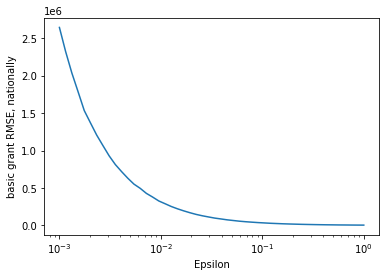

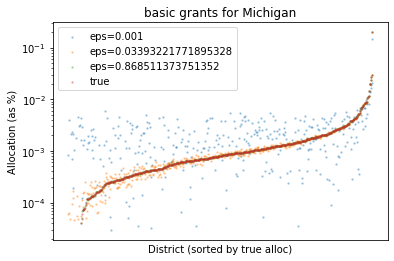

<ipython-input-28-f9aef1d67d38>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


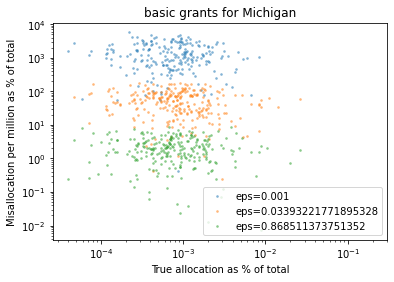

## concentration grants ##
RMSE at eps=0.10481131341546852: 142933.21184847507
Total misalloc at eps=0.10481131341546852: 361579342.8538623
Total true alloc: 29421416873.03583


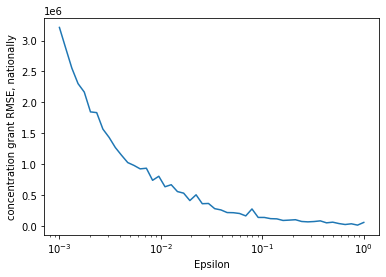

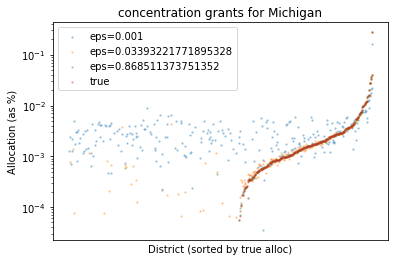

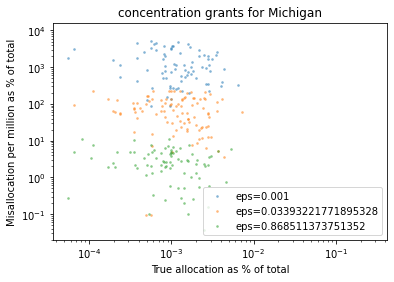

## targeted grants ##
RMSE at eps=0.10481131341546852: 78930.99498586728
Total misalloc at eps=0.10481131341546852: 536930757.1943287
Total true alloc: 66729811774.698265


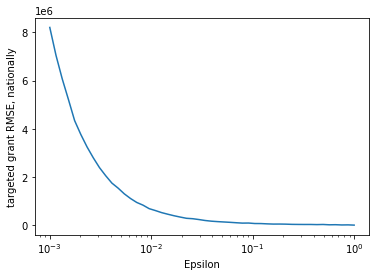

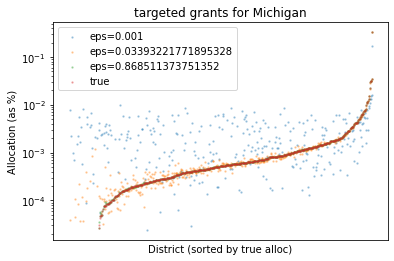

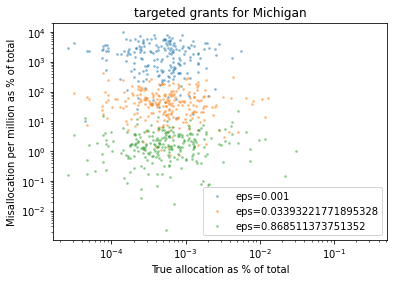

In [31]:
plot_results(results.loc[0.2])

Float64Index([               0.02, 0.11800000000000001,               0.216,
              0.31400000000000006, 0.41200000000000003,                0.51,
               0.6080000000000001,  0.7060000000000001,               0.804,
                            0.902],
             dtype='float64', name='delta')
## basic grants ##
RMSE at eps=0.10481131341546852: 46191.10530918266
Total misalloc at eps=0.10481131341546852: 472339382.17725414
Total true alloc: 39894838662.272514


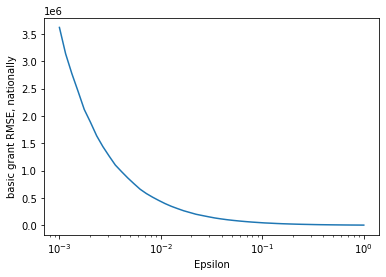

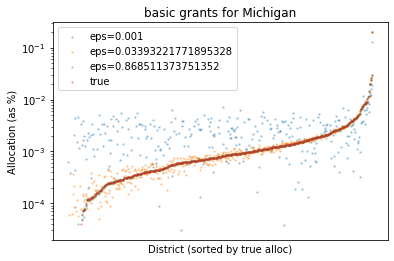

<ipython-input-28-f9aef1d67d38>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


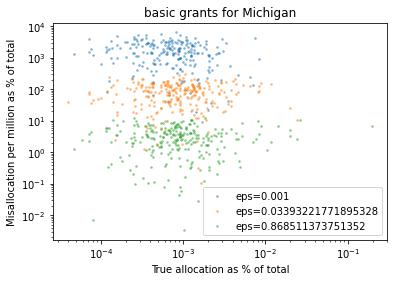

## concentration grants ##
RMSE at eps=0.10481131341546852: 164688.44996267467
Total misalloc at eps=0.10481131341546852: 482483117.5341026
Total true alloc: 29421416873.03583


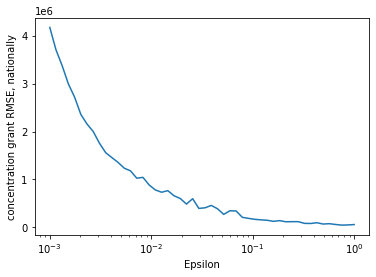

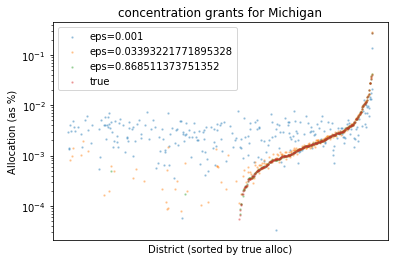

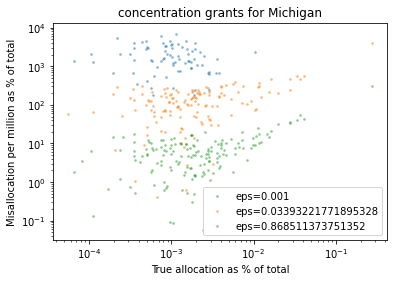

## targeted grants ##
RMSE at eps=0.10481131341546852: 107858.39893504622
Total misalloc at eps=0.10481131341546852: 758902088.9274584
Total true alloc: 66729811774.698265


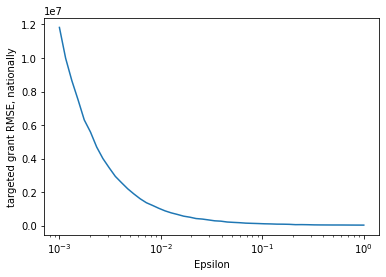

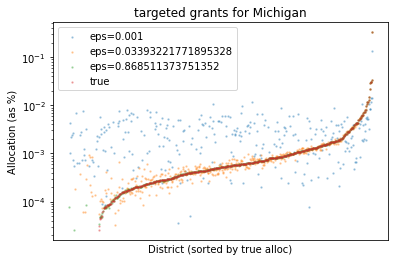

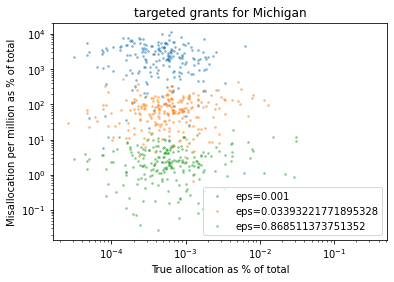

In [41]:
plot_results(results.loc[0.804])

# Discrimination
## Data
Using 2014-2018 ACS race data by school district from the NCES. See notes for more details.
1. Total
2. White alone
3. Black or African American alone
4. American Indian and Alaska Native alone
5. Asian alone
6. Native Hawaiian and Other Pacific Islander alone
7. Some other race alone
8. Two or more races
9. Two or more races: including Some other race
10. Two or more races: excluding Some other race, and three or more races

In [138]:
from dp_policy.titlei.utils import get_race

race = get_race("../data/sd_race18.txt")
race.head()

,,race_1est,race_1moe,race_2est,race_2moe,race_3est,race_3moe,race_4est,race_4moe,race_5est,race_5moe,race_6est,race_6moe,race_7est,race_7moe,race_8est,race_8moe,race_9est,race_9moe,race_10est,race_10moe
State FIPS Code,District ID,,,,,,,,,,,,,,,,,,,,
27,106,5663,242,5576,235,3,4,7,6,8,8,0,12,33,19,36,20,7,7,29,18
45,690,23553,252,16552,217,6325,278,0,23,80,109,0,23,51,43,545,205,52,67,493,206
55,30,3644,247,3339,251,19,15,4,7,8,6,0,9,241,106,33,25,0,9,33,25
48,7380,846,157,813,158,6,9,15,14,0,13,0,13,12,14,0,13,0,13,0,13
6,1620,107256,1060,29011,1494,6685,804,539,224,45448,1356,510,273,20125,1181,4938,747,1923,566,3015,473


In [141]:
saipe = get_saipe("../data/saipe19.xls")
saipe = saipe.join(race, how="inner")
saipe['prop_nonwhitealone'] = 1 - saipe.race_2est / saipe.race_1est

In [147]:
grants = funding(saipe, AbowdAllocator, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting)
error = grants.true_allocation - grants.est_allocation

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


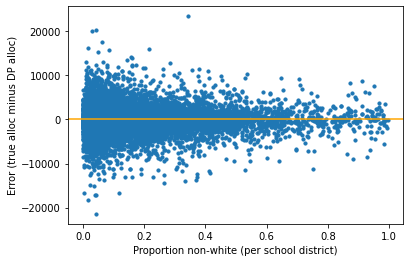

In [152]:
plt.scatter(grants.prop_nonwhitealone, error, s=10)
plt.axhline(y=0, xmin=0, xmax=1, color="orange")
plt.xlabel("Proportion non-white (per school district)")
plt.ylabel("Error (true alloc minus DP alloc)")
plt.show()

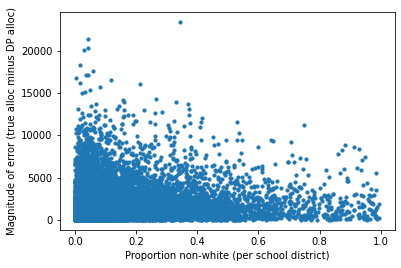

In [154]:
plt.scatter(grants.prop_nonwhitealone, np.abs(error), s=10)
plt.xlabel("Proportion non-white (per school district)")
plt.ylabel("Magnitude of error (true alloc minus DP alloc)")
plt.show()